In [1]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
np.random.seed(1234)

In [33]:
#Ground truth data distribution
def random_sample_old(d, Delta, N):
    y = np.random.randint(0,2,N)
    y = np.where(y==0, -1, y)
    x = np.zeros((N,d))
    for i in range(N):
        if y[i] == 1:
            x[i,:] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*d))
        if y[i] == -1:
            x[i,:] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*d))
    return x.reshape(N,d),y

In [34]:
#Ground truth data distribution
def random_sample(d, Delta, N):
    y = np.ones(N)
    x = np.zeros((N,d))
    successes = np.random.binomial(N, 0.5)
    y[successes:] *= -1
    x[:successes, :] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*d), successes)
    x[successes:, :] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*d), N-successes)
    #x = np.take(x,np.random.rand(x.shape[0]).argsort(),axis=0,out=x)
    
    return x.reshape(N,d),y

In [35]:
#activation function
def sigma(t, t1, s1, t2, s2):
    if t < t1:
        return s1
    elif t>t2:
        return s2
    else:
        return (s2-s1)/(t2-t1)*(t-t1)+s1
    
def grad_sigma(t, t1, s1, t2, s2):
    if t < t1:
        return 0
    elif t>t2:
        return 0
    else:
        return (s2-s1)/(t2-t1)
vgrad_sigma = np.vectorize(grad_sigma)
vsigma = np.vectorize(sigma)

In [36]:
#two layer neural net
def neural_net(x, θ):
    n = x.shape[0]
    out = vsigma(θ@x.T, 0.5, -2.5, 1.5, 7.5)
    return np.mean(out, axis = 0).reshape(n,1)

In [67]:
def stochastic_gradient_descent(d, Delta, N, epsilon = 1e-6, num_epochs = 1000):
    indices = [int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 60))]
    weights = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), N).reshape(N, d)
    risk = []
    mean_dist = []

    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        X = sample[0].reshape(1,d)
        y = sample[1]
        vgrad = vgrad_sigma(weights@X.T, 0.5, -2.5, 1.5, 7.5)
        gradient = vgrad.reshape(N,1)*(X).reshape(1,d)
        weights += 2*epsilon*(y-neural_net(X, weights))*gradient
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample-neural_net(x_sample,weights))**2)
            risk.append(mse)
            dist = np.mean(np.linalg.norm(weights, axis = 1))
            mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
        
    return weights, risk, mean_dist

In [84]:
#params
d = 40
N = 800
Delta = 0.8


weights, risk_SGD, mean_dist_SGD = stochastic_gradient_descent(d, Delta, N, epsilon = 1e-5, num_epochs = int(1e4))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 12, risk: 4.1429720431341925
Epoch: 14, risk: 4.174890740000578
Epoch: 17, risk: 4.167532621794192
Epoch: 19, risk: 4.1698734537828575
Epoch: 23, risk: 4.165106221301231
Epoch: 26, risk: 4.16134089449446
Epoch: 31, risk: 4.124102495483018
Epoch: 36, risk: 4.149924418279121
Epoch: 42, risk: 4.185146522471842
Epoch: 49, risk: 4.11639410170879
Epoch: 57, risk: 4.153099413138028
Epoch: 67, risk: 4.179682740456113
Epoch: 78, risk: 4.18632917304817
Epoch: 91, risk: 4.147797292077535
Epoch: 106, risk: 4.130082168240342
Epoch: 123, risk: 4.150683716503753
Epoch: 143, risk: 4.162897071030029
Epoch: 167, risk: 4.172989780307037
Epoch: 194, risk: 4.161700699766504
Epoch: 226, risk: 4.144861672902469
Epoch: 264, risk: 4.165205214963503
Epoch: 307, risk: 4.1665002246799725
Epoch: 358, risk: 4.173568353099318
Epoch: 417, risk: 4.177081238333852
Epoch: 485, risk: 4.154375528181488
Epoch: 565, risk: 4.1715307667585435
Epoch: 658, risk: 4.16236346779561
Epoch: 766, risk: 4.146427964747326
Epoch:

In [40]:
weights_norms = np.linalg.norm(weights, axis = 1)

(array([0.12696458, 0.06348229, 0.19044688, 0.19044688, 0.8252698 ,
        0.88875209, 1.71402189, 2.22188022, 2.53929168, 4.31679586,
        3.23759689, 4.38027815, 5.26903024, 3.93590211, 4.38027815,
        3.49152606, 3.36456148, 2.53929168, 2.34884481, 1.77750418,
        1.52357501, 0.69830521, 0.19044688, 0.31741146, 0.19044688,
        0.        , 0.        , 0.        , 0.        , 0.06348229]),
 array([0.56650465, 0.58619518, 0.60588571, 0.62557624, 0.64526677,
        0.6649573 , 0.68464783, 0.70433836, 0.72402889, 0.74371943,
        0.76340996, 0.78310049, 0.80279102, 0.82248155, 0.84217208,
        0.86186261, 0.88155314, 0.90124367, 0.9209342 , 0.94062473,
        0.96031526, 0.98000579, 0.99969632, 1.01938685, 1.03907738,
        1.05876791, 1.07845844, 1.09814897, 1.1178395 , 1.13753003,
        1.15722056]),
 <BarContainer object of 30 artists>)

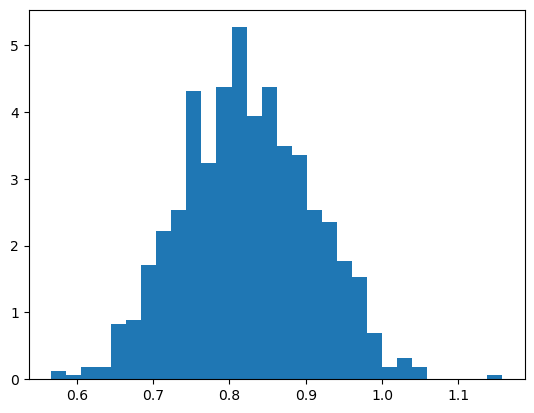

In [13]:
import matplotlib.pyplot as plt 
plt.hist(weights_norms, density = True,  bins = 30)

In [15]:
sample = random_sample(40, 0.8, 1)
x = sample[0][0]
y = sample[1]
print("pred: "+ str(neural_net(x, weights)))
print("actual:" + str(y))

ValueError: cannot reshape array of size 1 into shape (40,1)

In [74]:
def nesterov_accelerated_sgd(d, Delta, N, epsilon = 1e-6, r = 3, num_epochs = 1000):
    indices = [int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 60))]
    weights = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), N).reshape(N, d)
    lookahead = weights
    risk = []
    mean_dist = []

    for epoch in trange(1, num_epochs+1): 
        # Update the params 
        sample = random_sample(d,Delta,1)
        X = sample[0].reshape(1,d)
        y = sample[1]
        
        vgrad = vgrad_sigma(lookahead@X.T, 0.5, -2.5, 1.5, 7.5)
        gradient = vgrad.reshape(N,1)*(X).reshape(1,d)
        
        weights_new = lookahead + 2*epsilon*(y-neural_net(X, lookahead))*gradient
        lookahead = weights_new + ((epoch-1)/(epoch+r-1))*(weights_new - weights)
        weights = weights_new
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample-neural_net(x_sample,weights))**2)
            risk.append(mse)
            dist = np.mean(np.linalg.norm(weights, axis = 1))
            mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
        
    return weights, lookahead, risk, mean_dist

In [ ]:
#params
d = 40
N = 800
Delta = 0.8


weights_NSGD, momentum_NSGD, risk_NSGD, mean_dist_NSGD = nesterov_accelerated_sgd(d, Delta, N, epsilon = 1e-5, r=3, num_epochs = int(1e4))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 12, risk: 4.166580827103326
Epoch: 14, risk: 4.141524260578924
Epoch: 17, risk: 4.165546563591781
Epoch: 19, risk: 4.161156323743803
Epoch: 23, risk: 4.153776159074688
Epoch: 26, risk: 4.1723880385884975
Epoch: 31, risk: 4.13449275648278
Epoch: 36, risk: 4.174499568845029
Epoch: 42, risk: 4.167505790335081
Epoch: 49, risk: 4.165801780104115
Epoch: 57, risk: 4.168627336820112
Epoch: 67, risk: 4.184063545212886
Epoch: 78, risk: 4.180412975174764
Epoch: 91, risk: 4.157325331010033
Epoch: 106, risk: 4.156158894060684
Epoch: 123, risk: 4.18365709260684
Epoch: 143, risk: 4.168000698972858
Epoch: 167, risk: 4.164440370471191
Epoch: 194, risk: 4.1421204864072045
Epoch: 226, risk: 4.156835844935717
Epoch: 264, risk: 4.145219269261281
Epoch: 307, risk: 4.1513214663692795
Epoch: 358, risk: 4.153600318467237
Epoch: 417, risk: 4.138085490288749
Epoch: 485, risk: 4.17871119618528
Epoch: 565, risk: 4.193305484787206
Epoch: 658, risk: 4.2599948978699835
Epoch: 766, risk: 4.2578488228873095
Epoc

In [ ]:
#plot SGD and Nesterov SGD losses
indices = np.array([int(a) for a in 10**(np.linspace(1.1, np.log10(1e5), 60))])
plt.plot(indices, risk_SGD)
plt.scatter(indices, risk_SGD, marker = 'x', label = 'SGD risk')
plt.plot(indices, risk_NSGD, c = 'g')
plt.scatter(indices, risk_NSGD, marker = 'x', label = 'NSGD risk', c = 'g')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Risk')
plt.legend()
plt.title('SGD vs NSGD risk for Isotropic Gaussian')


In [16]:
from scipy.stats import norm

def q_plus(t, Delta):
    x = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f = 1 / (np.sqrt(2 * np.pi)) * vsigma((1 + Delta) * t * x, 0.5, -2.5, 1.5, 7.5) * np.exp(-x ** 2 / 2)
    integral = np.trapz(f, x)
    return integral -2.5*norm.cdf(0.5/((1+Delta)*t))+7.5*(1-norm.cdf(1.5/((1+Delta)*t)))
    #return integral

def q_minus(t, Delta):
    x = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f = 1 / (np.sqrt(2 * np.pi)) * vsigma((1 - Delta) * t * x, 0.5, -2.5, 1.5, 7.5) * np.exp(-x ** 2 / 2)
    integral = np.trapz(f, x)
    return integral -2.5*norm.cdf(0.5/((1-Delta)*t))+7.5*(1-norm.cdf(1.5/((1-Delta)*t)))
    #return integral

vq_plus = np.vectorize(q_plus)
vq_minus = np.vectorize(q_minus)

def dq_plus(t, Delta):
    x = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f = (1+Delta) / (np.sqrt(2 * np.pi)) * 10 * np.exp(-x ** 2 / 2)*x
    integral = np.trapz(f, x)
    return integral 

def dq_minus(t, Delta):
    x = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f = (1-Delta) / (np.sqrt(2 * np.pi)) * 10 * np.exp(-x ** 2 / 2)*x
    integral = np.trapz(f, x)
    return integral
    
vdq_plus = np.vectorize(dq_plus)
vdq_minus = np.vectorize(dq_minus)

def q_func(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus(t,0.8)
    elif flag == 1:
        return vq_minus(t,0.8)
    elif flag == 2:
        return vdq_plus(t,0.8)
    elif flag == 3:
        return vdq_minus(t,0.8)
    
def q_func_new(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus_new(t)
    elif flag == 1:
        return vq_minus_new(t)
    elif flag == 2:
        return vdq_plus_new(t)
    elif flag == 3:
        return vdq_minus_new(t)

def parallelise(t):
    with Pool(4) as p:
        results = np.array(p.map(q_func_new, [[t,0], [t,1], [t,2], [t,3]]))
    return results
vparallelise = np.vectorize(parallelise)

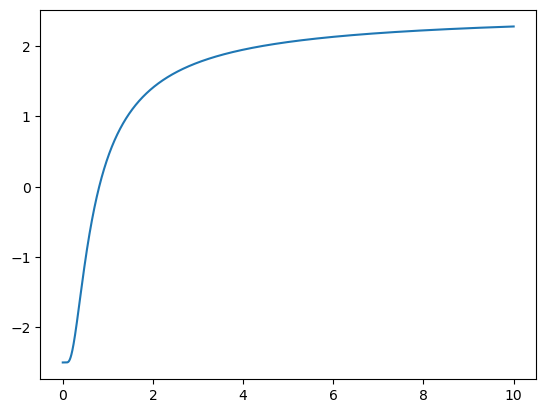

In [17]:
epsilon = 1e-6
Delta = 0.8
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_plus_vals = vq_plus(Interval_q, Delta)
plt.plot(Interval_q, q_plus_vals)

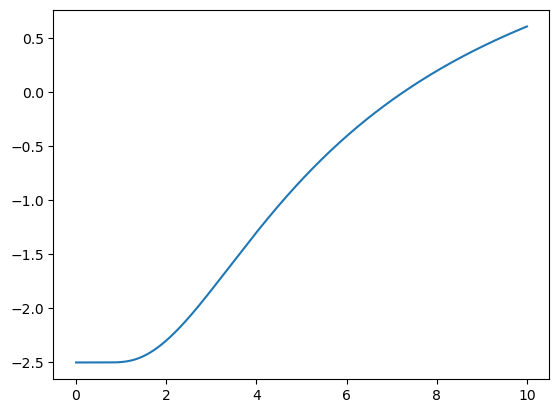

In [18]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_minus_vals = vq_minus(Interval_q, Delta)
plt.plot(Interval_q, q_minus_vals)

In [19]:
Q_plus = dict(zip(Interval_q, q_plus_vals))
Q_minus = dict(zip(Interval_q, q_minus_vals))

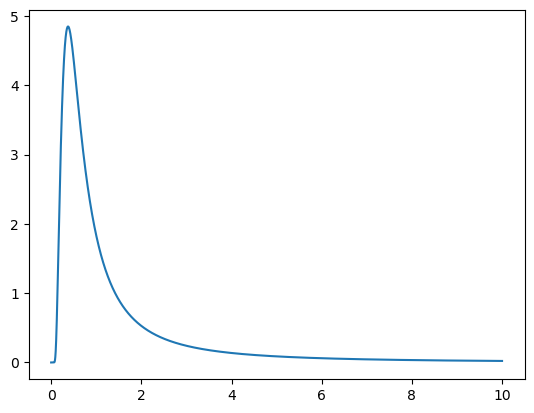

In [20]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_plus_vals = vdq_plus(Interval_q, Delta)
plt.plot(Interval_q, dq_plus_vals)

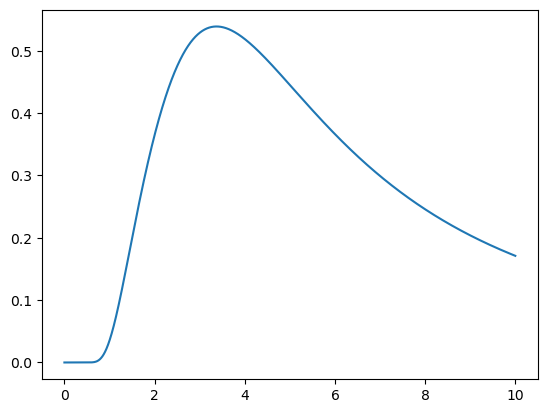

In [21]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_minus_vals = vdq_minus(Interval_q, Delta)
plt.plot(Interval_q, dq_minus_vals)

In [22]:
dQ_plus = dict(zip(Interval_q, dq_plus_vals))
dQ_minus = dict(zip(Interval_q, dq_minus_vals))

In [23]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
vfind_nearest = np.vectorize(find_nearest)

In [24]:
def q_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_plus[r_approx]

def q_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_minus[r_approx]

vq_plus_new = np.vectorize(q_plus_new)
vq_minus_new = np.vectorize(q_minus_new)

def dq_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_plus[r_approx]

def dq_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_minus[r_approx]

vdq_plus_new = np.vectorize(dq_plus_new)
vdq_minus_new = np.vectorize(dq_minus_new)


def R_inf(vq_plus, vq_minus, Delta):
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return 0.5 * (1 - mean_vq_plus) ** 2 + 0.5 * (1 + mean_vq_minus) ** 2

def grad_R_inf(r, vq_plus, vq_minus, dplus, dminus, Delta):
    J = len(r)
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return -1 / J * dplus * (1 - mean_vq_plus) + 1 / J * dminus * (1 + mean_vq_minus)

def update(r, dt, grad):
    J = len(r)
    return J * grad * dt

In [ ]:
#simulate pde
epsilon = 1e-6
Interval = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e3))
J = 400
Iters = 5
pde_vals = np.zeros((Iters,J))
Delta = 0.8
d = 40
separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]

In [ ]:
#simulate 100 times and obtain a histogram
processes_count = 4
for i in trange(Iters):
    Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
    r = np.linalg.norm(Z, axis = 1)
    for dt in tqdm(separations):
        ''''
        plus = vq_plus(r, Delta)
        minus = vq_minus(r, Delta)
        dplus = vdq_plus(r, Delta)
        dminus = vdq_minus(r, Delta)
        '''
        output = parallelise(r).reshape(4,J)
        plus = output[0]
        minus = output[1]
        dplus = output[2]
        dminus = output[3]
        
        grad = grad_R_inf(r, plus, minus, dplus, dminus, Delta)
        r = update(r,dt, grad)
        print(grad)
    pde_vals[i] = r

In [ ]:
import matplotlib.pyplot as plt
y = np.ndarray.flatten(pde_vals)
plt.hist(y, density = True, bins = 30)

In [ ]:
Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
r = np.linalg.norm(Z, axis = 1)
start = time.time()
plus = vq_plus_new(r)
minus = vq_minus_new(r)
dplus = vdq_plus_new(r)
dminus = vdq_minus_new(r)
print('Elapsed time: {}'.format(time.time()-start))

In [ ]:
Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
r = np.linalg.norm(Z, axis = 1)
start = time.time()
output = parallelise(r).reshape(4,J)
plus = output[0]
minus = output[1]
dplus = output[2]
dminus = output[3]
print('Elapsed time: {}'.format(time.time()-start))

## Simulate PDE risk

In [25]:
#simulate pde risk
def pde_sim(d, J, epsilon = 1e-6, Delta = 0.8):
    Interval = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e4))
    separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]
    processes_count = 4
    risk = np.zeros(Interval.shape[0])
    Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
    r = np.linalg.norm(Z, axis = 1)
    mean_dist = []
    for k in trange(len(separations)):
        dt = separations[k]
        plus = vq_plus(r, Delta)
        minus = vq_minus(r, Delta)
        dplus = vdq_plus(r, Delta)
        dminus = vdq_minus(r, Delta)
        
        inf_risk = R_inf(plus, minus, Delta)
        risk[k] = inf_risk
        d = np.mean(r)
        mean_dist.append(d)
        print('Epoch: {}, dist: {}'.format(k, inf_risk))
        grad = grad_R_inf(r, plus, minus, dplus, dminus, Delta)
        r = r - update(r,dt, grad)
    plus = vq_plus(r, Delta)
    minus = vq_minus(r, Delta)
    inf_risk = R_inf(plus, minus, Delta)
    risk[-1] = inf_risk
    mean_dist.append(np.mean(r))
    return risk, mean_dist

In [26]:
d = 40
J = 400
risk_pde, mean_dist_pde = pde_sim(d, J, epsilon = 1e-6, Delta = 0.8)

  0%|          | 0/9999 [00:00<?, ?it/s]

Epoch: 0, dist: 1.6887476511353685
Epoch: 1, dist: 1.6887476511330657
Epoch: 2, dist: 1.6887476511307566
Epoch: 3, dist: 1.6887476511284403
Epoch: 4, dist: 1.6887476511261181
Epoch: 5, dist: 1.6887476511237907
Epoch: 6, dist: 1.6887476511214554
Epoch: 7, dist: 1.688747651119114
Epoch: 8, dist: 1.6887476511167665
Epoch: 9, dist: 1.6887476511144117
Epoch: 10, dist: 1.6887476511120516
Epoch: 11, dist: 1.688747651109684
Epoch: 12, dist: 1.6887476511073096
Epoch: 13, dist: 1.6887476511049295
Epoch: 14, dist: 1.6887476511025425
Epoch: 15, dist: 1.6887476511001487
Epoch: 16, dist: 1.688747651097748
Epoch: 17, dist: 1.6887476510953414
Epoch: 18, dist: 1.6887476510929276
Epoch: 19, dist: 1.6887476510905075
Epoch: 20, dist: 1.6887476510880803
Epoch: 21, dist: 1.6887476510856472
Epoch: 22, dist: 1.6887476510832067
Epoch: 23, dist: 1.6887476510807595
Epoch: 24, dist: 1.6887476510783053
Epoch: 25, dist: 1.6887476510758443
Epoch: 26, dist: 1.6887476510733777
Epoch: 27, dist: 1.6887476510709023
Epoch

Epoch: 226, dist: 1.688747650413562
Epoch: 227, dist: 1.6887476504092613
Epoch: 228, dist: 1.6887476504049497
Epoch: 229, dist: 1.6887476504006258
Epoch: 230, dist: 1.6887476503962904
Epoch: 231, dist: 1.6887476503919423
Epoch: 232, dist: 1.6887476503875818
Epoch: 233, dist: 1.6887476503832095
Epoch: 234, dist: 1.6887476503788252
Epoch: 235, dist: 1.6887476503744296
Epoch: 236, dist: 1.6887476503700203
Epoch: 237, dist: 1.6887476503655998
Epoch: 238, dist: 1.688747650361167
Epoch: 239, dist: 1.6887476503567211
Epoch: 240, dist: 1.6887476503522638
Epoch: 241, dist: 1.688747650347794
Epoch: 242, dist: 1.6887476503433125
Epoch: 243, dist: 1.6887476503388172
Epoch: 244, dist: 1.68874765033431
Epoch: 245, dist: 1.6887476503297907
Epoch: 246, dist: 1.6887476503252592
Epoch: 247, dist: 1.6887476503207144
Epoch: 248, dist: 1.6887476503161571
Epoch: 249, dist: 1.688747650311587
Epoch: 250, dist: 1.6887476503070047
Epoch: 251, dist: 1.6887476503024104
Epoch: 252, dist: 1.6887476502978018
Epoch: 

Epoch: 449, dist: 1.6887476490896502
Epoch: 450, dist: 1.6887476490816868
Epoch: 451, dist: 1.6887476490737008
Epoch: 452, dist: 1.6887476490656925
Epoch: 453, dist: 1.6887476490576625
Epoch: 454, dist: 1.6887476490496096
Epoch: 455, dist: 1.6887476490415358
Epoch: 456, dist: 1.6887476490334385
Epoch: 457, dist: 1.6887476490253195
Epoch: 458, dist: 1.6887476490171776
Epoch: 459, dist: 1.6887476490090134
Epoch: 460, dist: 1.6887476490008273
Epoch: 461, dist: 1.6887476489926168
Epoch: 462, dist: 1.6887476489843845
Epoch: 463, dist: 1.6887476489761295
Epoch: 464, dist: 1.6887476489678517
Epoch: 465, dist: 1.6887476489595512
Epoch: 466, dist: 1.6887476489512276
Epoch: 467, dist: 1.6887476489428805
Epoch: 468, dist: 1.6887476489345103
Epoch: 469, dist: 1.6887476489261173
Epoch: 470, dist: 1.6887476489177007
Epoch: 471, dist: 1.688747648909262
Epoch: 472, dist: 1.6887476489007993
Epoch: 473, dist: 1.688747648892312
Epoch: 474, dist: 1.688747648883803
Epoch: 475, dist: 1.6887476488752684
Epoc

KeyboardInterrupt: 

In [28]:
epsilon = 1e-6
Interval = 10**np.linspace(-5, np.log10(epsilon*1e7), int(1e5))

discretised_pde = lambda k: risk_pde[np.abs(Interval - epsilon**(4/4)*k).argmin()]
pde_loss = np.vectorize(discretised_pde)

iters = np.arange(1, int(1e4+1))
indices = [int(a) for a in 10**(np.linspace(1.1, 4, 60))]

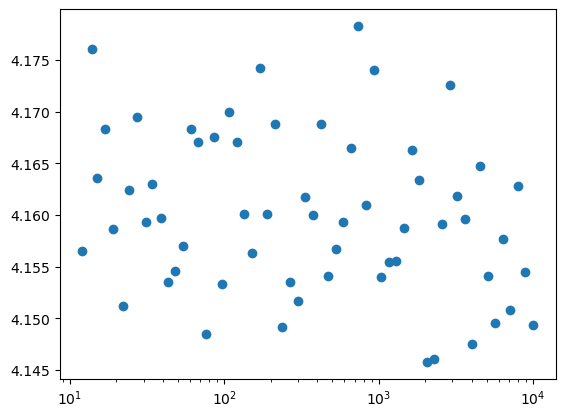

In [42]:
#plt.plot(iters, pde_loss(iters))
plt.scatter(indices, risk_SGD)
plt.xscale('log')